# DataSet Performance

This notebook shows the tradeoffs between inserting data into the database row by row and as binary blobs.
There is a tradeoff between inserting the data in these to ways. 


Inserting the data row by row means that we direct access to all the data and may perform querys directly on the values of the data. On the other hand as we will see below this is much slower than inserting the data direcly as binary blobs

In [1]:
%matplotlib notebook
import time
import matplotlib.pyplot as plt
import numpy as np

import qcodes as qc
from qcodes.instrument.parameter import ManualParameter
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement

In [2]:
initialise_database()
new_experiment(name='tutorial_exp', sample_name="no sample")

tutorial_exp#no sample#10@c:\Users\jenielse\mymainfolder\experiments.db
-----------------------------------------------------------------------

Here we define a simple function to benchmark the time it takes to insert n points with either numeric or array data type.
We will compare both the time used to call add_result and the time used for the full measurement.

In [3]:
def insert_data(paramtype, npoints, nreps=1):

    meas = Measurement()

    x1 = ManualParameter('x1')
    x2 = ManualParameter('x2')
    x3 = ManualParameter('x3')
    y1 = ManualParameter('y1')
    y2 = ManualParameter('y2')

    meas.register_parameter(x1, paramtype=paramtype)
    meas.register_parameter(x2, paramtype=paramtype)
    meas.register_parameter(x3, paramtype=paramtype)
    meas.register_parameter(y1, setpoints=[x1, x2, x3],
                            paramtype=paramtype)
    meas.register_parameter(y2, setpoints=[x1, x2, x3],
                            paramtype=paramtype)
    start = time.perf_counter()
    with meas.run() as datasaver:
        start_adding = time.perf_counter()
        for i in range(nreps):
            datasaver.add_result((x1, np.random.rand(npoints)),
                                 (x2, np.random.rand(npoints)),
                                 (x3, np.random.rand(npoints)),
                                 (y1, np.random.rand(npoints)),
                                 (y2, np.random.rand(npoints)))
        stop_adding = time.perf_counter()
        run_id = datasaver.run_id
    stop = time.perf_counter()
    tot_time = stop - start
    add_time = stop_adding - start_adding
    return tot_time, add_time, run_id

And perform a quick comparison of the two 

In [4]:
sizes = [1,10,100,5000,10000]
t_numeric = []
t_numeric_add = []
t_array = []
t_array_add = []
for size in sizes:
    tn, tna, run_id_n =  insert_data('numeric', size)
    t_numeric.append(tn)
    t_numeric_add.append(tna)

    ta, taa, run_id_a =  insert_data('array', size)
    t_array.append(ta)
    t_array_add.append(taa)

Starting experimental run with id: 341
Starting experimental run with id: 342
Starting experimental run with id: 343
Starting experimental run with id: 344
Starting experimental run with id: 345
Starting experimental run with id: 346
Starting experimental run with id: 347
Starting experimental run with id: 348
Starting experimental run with id: 349
Starting experimental run with id: 350


<IPython.core.display.Javascript object>


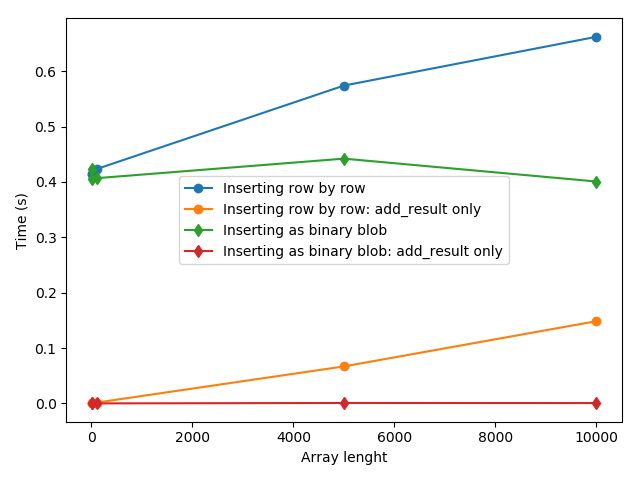

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes, t_numeric, 'o-', label='Inserting row by row')
ax.plot(sizes, t_numeric_add, 'o-', label='Inserting row by row: add_result only')
ax.plot(sizes, t_array, 'd-', label='Inserting as binary blob')
ax.plot(sizes, t_array_add, 'd-', label='Inserting as binary blob: add_result only')
ax.legend()
ax.set_xlabel('Array lenght')
ax.set_ylabel('Time (s)')
fig.tight_layout()

As we can see there the time to setup and and close the experiment is approximately 0.4 sec. At small array sizes the difference between inserting as arrays and inserting row by row is therefore relatively unimportant

In [6]:
sizes = [1,10,100,5000,10000]
nreps = 100
t_numeric = []
t_numeric_add = []
t_array = []
t_array_add = []
for size in sizes:
    tn, tna, run_id_n =  insert_data('numeric', size, nreps=nreps)
    t_numeric.append(tn)
    t_numeric_add.append(tna)

    ta, taa, run_id_a =  insert_data('array', size, nreps=nreps)
    t_array.append(ta)
    t_array_add.append(taa)

Starting experimental run with id: 351
Starting experimental run with id: 352
Starting experimental run with id: 353
Starting experimental run with id: 354
Starting experimental run with id: 355
Starting experimental run with id: 356
Starting experimental run with id: 357
Starting experimental run with id: 358
Starting experimental run with id: 359
Starting experimental run with id: 360


<IPython.core.display.Javascript object>


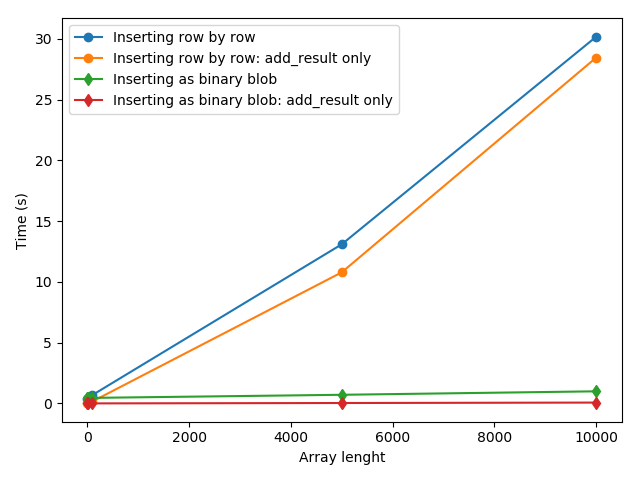

In [7]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes, t_numeric, 'o-', label='Inserting row by row')
ax.plot(sizes, t_numeric_add, 'o-', label='Inserting row by row: add_result only')
ax.plot(sizes, t_array, 'd-', label='Inserting as binary blob')
ax.plot(sizes, t_array_add, 'd-', label='Inserting as binary blob: add_result only')
ax.legend()
ax.set_xlabel('Array lenght')
ax.set_ylabel('Time (s)')
fig.tight_layout()

However, as we increase the length of the experimenter as seen here by repeating the insertion 100 times we see a big difference between inserting row by row and inserting as a binary blob

In [8]:
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id

As usual you can load the data using load_by_id but you will notice that the different storage methods
are reflected in shape of the data as is is retried. 

In [9]:
ds = load_by_id(run_id_n)
ds.get_data('x1')

[[0.303935108296429],
 [0.205688910134659],
 [0.0190937554077066],
 [0.773880641610748],
 [0.346697643711447],
 [0.495719575604383],
 [0.185015966255913],
 [0.80599949776169],
 [0.102707005441855],
 [0.904473262067972],
 [0.0357101160636203],
 [0.945067591537012],
 [0.727828094578624],
 [0.641208804317217],
 [0.0775174261943572],
 [0.831189218929039],
 [0.367378555252333],
 [0.837347033773553],
 [0.171903180699492],
 [0.0447834167353514],
 [0.00147763562166614],
 [0.0848363118822469],
 [0.443821490484684],
 [0.239110065829381],
 [0.207223959426337],
 [0.721914166040762],
 [0.380638044324181],
 [0.531596900224144],
 [0.463293239286207],
 [0.0527062550727871],
 [0.467513069004392],
 [0.570275409783349],
 [0.919568919897176],
 [0.0210447683398854],
 [0.453905782709025],
 [0.104189191446325],
 [0.963602873567336],
 [0.822328624161126],
 [0.650061530468638],
 [0.26960766251706],
 [0.164127408478614],
 [0.793268028350197],
 [0.0502497641370556],
 [0.564781823839055],
 [0.430993527808597],
 [

And a dataset stored as binary arrays

In [10]:
ds = load_by_id(run_id_a)
ds.get_data('x1')

[[array([0.88054536, 0.93599775, 0.31633704, ..., 0.58082062, 0.67039551,
         0.01271646])],
 [array([0.46583634, 0.48856685, 0.17247764, ..., 0.47112011, 0.04144385,
         0.31601943])],
 [array([0.50452133, 0.19326102, 0.07237829, ..., 0.77065921, 0.88614413,
         0.6042738 ])],
 [array([0.0832373 , 0.6424893 , 0.28574411, ..., 0.62819778, 0.59090992,
         0.0130202 ])],
 [array([6.13856569e-02, 4.01958897e-01, 3.30168798e-01, ...,
         1.66087415e-01, 3.53840771e-04, 4.52615051e-01])],
 [array([0.24355672, 0.06220221, 0.03797401, ..., 0.13995834, 0.27425599,
         0.34784775])],
 [array([0.04228164, 0.57407551, 0.36138676, ..., 0.89206428, 0.07141132,
         0.64099271])],
 [array([0.1451565 , 0.21798964, 0.2097668 , ..., 0.79680647, 0.51491199,
         0.04998325])],
 [array([0.72163144, 0.16923405, 0.97331005, ..., 0.75143802, 0.45704672,
         0.25350092])],
 [array([0.55362892, 0.8374911 , 0.66302427, ..., 0.31494978, 0.51785727,
         0.560795  ]

A better solution may be to use get_data_by_id which will load the data in a format that does not depend on the internal storage

In [11]:
get_data_by_id(run_id_n)

[[{'name': 'x1',
   'label': 'x1',
   'unit': '',
   'data': array([0.30393511, 0.20568891, 0.01909376, ..., 0.18783573, 0.81385152,
          0.922575  ])},
  {'name': 'x2',
   'label': 'x2',
   'unit': '',
   'data': array([0.71339061, 0.41536389, 0.85355781, ..., 0.86037541, 0.55157323,
          0.28043206])},
  {'name': 'x3',
   'label': 'x3',
   'unit': '',
   'data': array([0.3996946 , 0.04257741, 0.34440495, ..., 0.40003674, 0.48460096,
          0.55265484])},
  {'name': 'y1',
   'label': 'y1',
   'unit': '',
   'data': array([0.59312413, 0.19470313, 0.76987827, ..., 0.82354578, 0.69146081,
          0.81527588])}],
 [{'name': 'x1',
   'label': 'x1',
   'unit': '',
   'data': array([0.30393511, 0.20568891, 0.01909376, ..., 0.18783573, 0.81385152,
          0.922575  ])},
  {'name': 'x2',
   'label': 'x2',
   'unit': '',
   'data': array([0.71339061, 0.41536389, 0.85355781, ..., 0.86037541, 0.55157323,
          0.28043206])},
  {'name': 'x3',
   'label': 'x3',
   'unit': '',
 

In [12]:
get_data_by_id(run_id_a)

[[{'name': 'x1',
   'label': 'x1',
   'unit': '',
   'data': array([0.88054536, 0.93599775, 0.31633704, ..., 0.16317358, 0.76142152,
          0.11574115])},
  {'name': 'x2',
   'label': 'x2',
   'unit': '',
   'data': array([0.80922516, 0.57728979, 0.86526591, ..., 0.66355582, 0.19470214,
          0.51558843])},
  {'name': 'x3',
   'label': 'x3',
   'unit': '',
   'data': array([0.53956189, 0.85340242, 0.92120858, ..., 0.13467366, 0.6637258 ,
          0.63421746])},
  {'name': 'y1',
   'label': 'y1',
   'unit': '',
   'data': array([0.73805894, 0.29234849, 0.15297761, ..., 0.76734526, 0.47733854,
          0.94968976])}],
 [{'name': 'x1',
   'label': 'x1',
   'unit': '',
   'data': array([0.88054536, 0.93599775, 0.31633704, ..., 0.16317358, 0.76142152,
          0.11574115])},
  {'name': 'x2',
   'label': 'x2',
   'unit': '',
   'data': array([0.80922516, 0.57728979, 0.86526591, ..., 0.66355582, 0.19470214,
          0.51558843])},
  {'name': 'x3',
   'label': 'x3',
   'unit': '',
 